In [1]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 1. Data Collecting

Tahapan ini ada pada `scraping.ipynb` yang dimana kita mengambil dataset sejumlah 12.000 review dari google play store menggunakan `google-play-scraper`

### 2. Data Preprocessing

#### a. Data Info

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import seaborn as sns
from prettytable import PrettyTable


In [3]:
df = pd.read_csv('./dataset/reviews.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   reviewId  12000 non-null  object
 1   userName  12000 non-null  object
 2   content   12000 non-null  object
 3   score     12000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 375.1+ KB


#### b. Data Sample

In [4]:
df.head()

reviewId                userName  \
0  eeb31930-2431-428a-9f4e-baf93928cf94  Dzaki Abdullah Fawwaaz   
1  cf26cb0f-e84c-4c0d-93a6-613f1fe34cec             Ajeng Rasti   
2  d36cfcac-6ac9-40ff-ab44-f59b345e35fa              Yanti Baru   
3  b42f0cbb-da51-403d-b23a-10b571ff007e       Muh.fauzan Fausan   
4  f2a1e9dd-e3d2-4b4b-ae0c-1d167f19a047          Rina Rahmawati   

                                             content  score  
0  GAME NYA BAGUS BANGET, MULAI DARI STORY, EVENT...      5  
1                                       Scaramouche.      5  
2  Yah pokoknya bagus deh Grafik bagus . Karakter...      5  
3  Grafik nya mantap pol tapi aku masih download ...      5  
4                                         Game bagus      5

#### c. Data Sentiment

Di kita akan menambahkan kolom baru pada DataFrame yaitu `sentiments` untuk membagi kelompok dari review. 0 untuk `score <= 2` dan 1 untuk `score >= 3`

In [5]:
df['sentiments'] = df.score.apply(lambda x: 0 if x in [1, 2] else 1)

### 3. Data Analysis and Visualization

In [6]:
import matplotlib.pyplot as plt

#### a. Visualisasi terhadapat sentiment

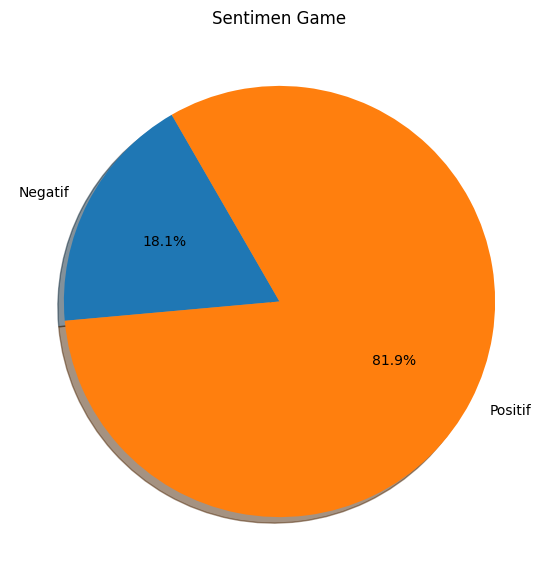

In [7]:
plt.figure(figsize=(15,7))
# sentimen = df.dropna(subset=['sentiments']).sort_values(by=['sentiments'])['sentiments'].unique()
total = df.groupby(['sentiments'])['score'].count()
plt.pie(total, labels=(["Negatif", "Positif"]), autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Sentimen Game')
plt.show()


#### b. Visualisasi Terhadap Rating

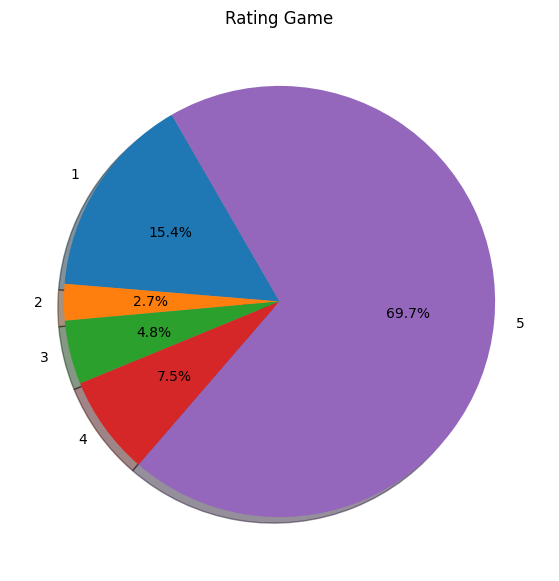

In [8]:
plt.figure(figsize=(15,7))
rating = df.dropna(subset=['score']).sort_values(by=['score'])['score'].unique()
total = df.groupby(['score'])['reviewId'].count()
plt.pie(total, labels=rating, autopct='%.1f%%', startangle = 120, shadow = True)
plt.title('Rating Game')
plt.show()


#### c. Visualisasi Kata ter Banyak dengan Word Cloud

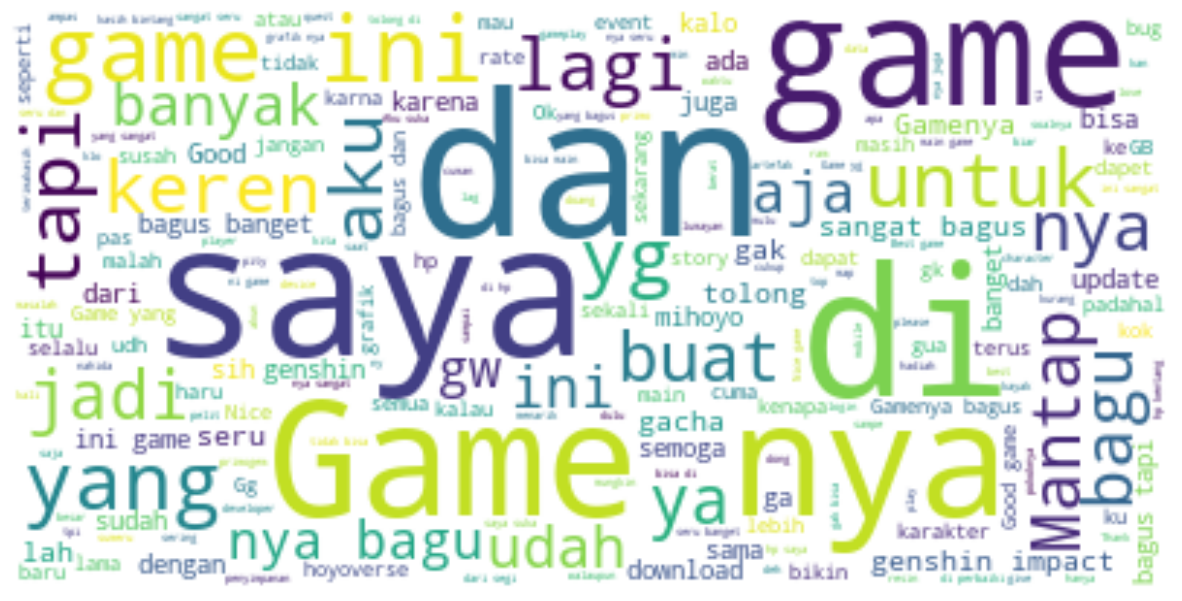

In [9]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd


text = " ".join(i for i in df.content)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Data Modeling

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(oov_token="<OOV>")

In [11]:
x_train, x_test, y_train, y_test = train_test_split(df['content'], df['sentiments'], test_size=0.4, shuffle=True)


In [12]:
import numpy as np
training_sentences = []
training_labels = []
testing_sentences = []
testing_labels = []
for row in x_train:
    training_sentences.append(str(row))
for row in y_train:
    training_labels.append(row)
for row in x_test:
    testing_sentences.append(str(row))
for row in y_test:
    testing_labels.append(row)


In [13]:
vocab_size = 40000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
padding_type = 'post'

In [14]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index


table=PrettyTable(['Kata', 'Urutan'])
x=1
for i in word_index:
    table.add_row([i,x])
    x+=1
# word_index 
print(table)
# word_index


+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+
|                                                                                                                                                                           Kata                                                                                                                                                                           | Urutan |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sentences, maxlen=max_length)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           640000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_________________________________________________________________


In [33]:
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
testing_labels_final

array([1, 1, 0, ..., 1, 1, 1])

In [46]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0716 - accuracy: 0.9778 - val_loss: 0.4818 - val_accuracy: 0.8442
Epoch 2/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0711 - accuracy: 0.9781 - val_loss: 0.4876 - val_accuracy: 0.8452
Epoch 3/10
225/225 [==============================] - 2s 7ms/step - loss: 0.0699 - accuracy: 0.9797 - val_loss: 0.4915 - val_accuracy: 0.8446
Epoch 4/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0669 - accuracy: 0.9787 - val_loss: 0.4956 - val_accuracy: 0.8444
Epoch 5/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0665 - accuracy: 0.9799 - val_loss: 0.5011 - val_accuracy: 0.8425
Epoch 6/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0664 - accuracy: 0.9790 - val_loss: 0.5063 - val_accuracy: 0.8448
Epoch 7/10
225/225 [==============================] - 1s 6ms/step - loss: 0.0626 - accuracy: 0.9799 - val_loss: 0.5209 - val_accuracy: 0.8425
Epoch 

<AxesSubplot: >

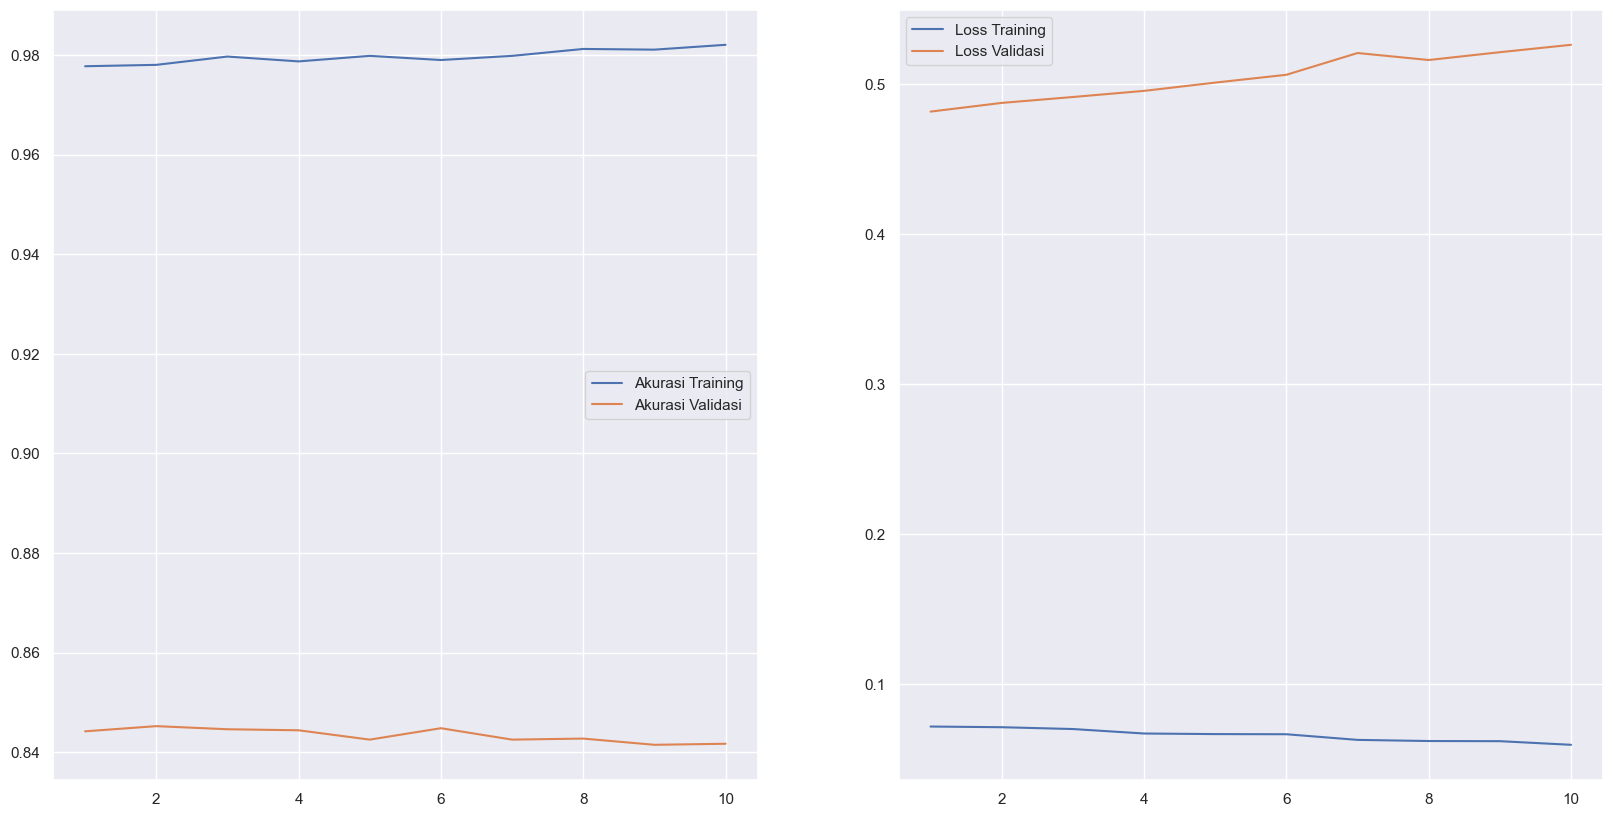

In [47]:
epochs = [i+1 for i in range(num_epochs)]

sns.set_theme()

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.lineplot(x=epochs, y=history.history['accuracy'], label='Akurasi Training')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], label='Akurasi Validasi')
plt.subplot(1,2,2)
sns.lineplot(x=epochs, y=history.history['loss'], label='Loss Training')
sns.lineplot(x=epochs, y=history.history['val_loss'], label='Loss Validasi')

In [48]:
predict_sentences = tokenizer.texts_to_sequences(["gamenya babi"])
predict_padded = pad_sequences(predict_sentences, maxlen=max_length)

model.predict(predict_padded)

1/1 [==============================] - 0s 20ms/step


array([[0.5142518]], dtype=float32)